In [1]:
import sys
import torch  
import gym
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# REINFORCE BASELINE VALUE FUNCTION

In [2]:
# Constants
GAMMA = 0.99

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        #Choose action with regard to policy
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) #log for gradient
        return highest_prob_action, log_prob

In [3]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ValueNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.linear1(state))
        value = self.linear2(value)
        return value

In [4]:
def update_policy(policy_network, trajectories_gradient):
    policy_network.optimizer.zero_grad()    
    policy_gradient = torch.stack(trajectories_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [5]:
def count_trajectory(rewards, log_probs, baseline, policy_learning = False):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt, bs in zip(log_probs, discounted_rewards, baseline):
        if log_prob == 0:
            policy_gradient.append(torch.tensor([[0.0]], requires_grad = True))
        else:
            policy_gradient.append(-log_prob * (Gt - bs))
    
    if policy_learning:
        policy_gradient = torch.stack(policy_gradient).sum()
    return policy_gradient

In [6]:
def align_columns_zeros(array):
    max_length = max(list(map(lambda x: len(x), array)))
    for col in range(len(array)):
        array[col] = np.pad(array[col], max_length - len(array[col]), 'constant', constant_values = 0)[max_length - len(array[col]):]
    return array

In [17]:
def baseline_approximation(policy_net, value_net, val_optimizer, n_trajectories, n_epoch = 4000, early_stopping_rounds = 250):
    max_steps = 10000
    min_loss = float('inf')
    stopping_rounds = 0
    epoch = 1
    while(stopping_rounds < early_stopping_rounds and epoch < n_epoch):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        log_probs = [[] for i in range(n_trajectories)]
        baseline_values = [[] for i in range(n_trajectories)]
    
        for trajectory in range(n_trajectories):
            state = env.reset()
            
            for steps in range(max_steps):
                baseline = value_net.forward(state)
                action, log_prob = policy_net.get_action(state)
                new_state, reward, done, _ = env.step(action)
                baseline_values[trajectory].append(baseline)
                log_probs[trajectory].append(log_prob)
                rewards[trajectory].append(reward)
                if done:                    
                    break
                state = new_state
        rewards = align_columns_zeros(rewards)
        log_probs = align_columns_zeros(log_probs)
        baseline_values = align_columns_zeros(baseline_values)
        for col in range(len(rewards)):
            traj = count_trajectory(rewards[col], log_probs[col], baseline_values[col])
            r_gradient.append(traj)
            
        r_gradient = list(map(lambda x: torch.stack(x), r_gradient))
        r_gradient = torch.stack(r_gradient)
        
        value_loss = torch.var(r_gradient, 1).sum()
        if value_loss < min_loss:
            min_loss = value_loss
            torch.save(value_net, 'model.pth')
            stopping_rounds = 0
        else:
            stopping_rounds += 1
        print('{}. Value loss = {}, early stopping rounds = {}'.format(epoch, value_loss, stopping_rounds))
        epoch += 1
        val_optimizer.zero_grad()
        value_loss.backward()
        val_optimizer.step()
    value_net = torch.load('model.pth')

In [8]:
def cart_pole_baseline(value_net, n_trajectories = 2, episode_num = 1500):
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)
    

    max_episode_num = episode_num
    max_steps = 10000
    numsteps = [[] for i in range(n_trajectories)]
    avg_numsteps = [[] for i in range(n_trajectories)]
    all_rewards = [[] for i in range(n_trajectories)]

    for episode in range(max_episode_num):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        baseline_values = []
        
        for trajectory in range(n_trajectories):
            state = env.reset()
            log_probs = []
            
            for steps in range(max_steps):
                #env.render()
                baseline = value_net.forward(state)
                action, log_prob = policy_net.get_action(state)
                new_state, reward, done, _ = env.step(action)
                log_probs.append(log_prob)
                rewards[trajectory].append(reward)
                baseline_values.append(baseline)
                
                if done:
                    traj = count_trajectory(rewards[trajectory], log_probs, baseline_values, True)                       
                    r_gradient.append(traj)
                    numsteps[trajectory].append(steps)
                    avg_numsteps[trajectory].append(np.mean(numsteps[trajectory][-10:]))
                    all_rewards[trajectory].append(np.sum(rewards[trajectory]))
                    break

                state = new_state
                
        update_policy(policy_net, r_gradient)                 
        rewards = align_columns_zeros(rewards)
        #print(all_rewards)
        if episode % 10 == 0:
            sys.stdout.write("episode: {}, total mean reward among trajectories: {}, average_reward_among_trajectories: {}\n".\
                                     format(episode, np.round(np.mean(np.sum(rewards, axis = 1)), decimals = 3),\
                                            np.round(np.mean(np.mean(all_rewards, axis = 0)[-10:]), decimals = 3)))
        
    return all_rewards, avg_numsteps 

In [20]:
%%time
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)
value_net = ValueNetwork(env.observation_space.shape[0], env.action_space.n, 256)
val_optimizer = optim.Adam(value_net.parameters(), lr=3e-4)
baseline_approximation(policy_net, value_net, val_optimizer, 3, early_stopping_rounds=300)

1. Value loss = 1.098846673965454, early stopping rounds = 0
2. Value loss = 1.0848219394683838, early stopping rounds = 0
3. Value loss = 0.9539957046508789, early stopping rounds = 0
4. Value loss = 1.333022952079773, early stopping rounds = 1
5. Value loss = 1.01021409034729, early stopping rounds = 2
6. Value loss = 1.02125883102417, early stopping rounds = 3
7. Value loss = 1.012012004852295, early stopping rounds = 4
8. Value loss = 1.0193443298339844, early stopping rounds = 5
9. Value loss = 1.2451457977294922, early stopping rounds = 6
10. Value loss = 1.0480029582977295, early stopping rounds = 7
11. Value loss = 1.3022887706756592, early stopping rounds = 8
12. Value loss = 1.0029304027557373, early stopping rounds = 9
13. Value loss = 1.0567429065704346, early stopping rounds = 10
14. Value loss = 1.0982661247253418, early stopping rounds = 11
15. Value loss = 0.9733614921569824, early stopping rounds = 12
16. Value loss = 0.9768291711807251, early stopping rounds = 13
17. 

132. Value loss = 0.5433728694915771, early stopping rounds = 8
133. Value loss = 0.9375046491622925, early stopping rounds = 9
134. Value loss = 0.8059284687042236, early stopping rounds = 10
135. Value loss = 0.930010199546814, early stopping rounds = 11
136. Value loss = 0.608086347579956, early stopping rounds = 12
137. Value loss = 0.5174002647399902, early stopping rounds = 13
138. Value loss = 0.504613995552063, early stopping rounds = 14
139. Value loss = 0.8077307343482971, early stopping rounds = 15
140. Value loss = 0.5474576354026794, early stopping rounds = 16
141. Value loss = 0.7732506990432739, early stopping rounds = 17
142. Value loss = 0.6658146977424622, early stopping rounds = 18
143. Value loss = 0.6518353819847107, early stopping rounds = 19
144. Value loss = 0.6833676099777222, early stopping rounds = 20
145. Value loss = 0.669350266456604, early stopping rounds = 21
146. Value loss = 0.851569414138794, early stopping rounds = 22
147. Value loss = 0.736138343811

260. Value loss = 0.709661602973938, early stopping rounds = 10
261. Value loss = 0.4963136911392212, early stopping rounds = 11
262. Value loss = 0.7210271954536438, early stopping rounds = 12
263. Value loss = 0.5770785808563232, early stopping rounds = 13
264. Value loss = 0.45145270228385925, early stopping rounds = 14
265. Value loss = 0.4377697706222534, early stopping rounds = 15
266. Value loss = 0.6674507260322571, early stopping rounds = 16
267. Value loss = 0.5088659524917603, early stopping rounds = 17
268. Value loss = 0.563488245010376, early stopping rounds = 18
269. Value loss = 0.6936812996864319, early stopping rounds = 19
270. Value loss = 0.6794683337211609, early stopping rounds = 20
271. Value loss = 0.4393460154533386, early stopping rounds = 21
272. Value loss = 0.6579006910324097, early stopping rounds = 22
273. Value loss = 0.6279405355453491, early stopping rounds = 23
274. Value loss = 0.4545607268810272, early stopping rounds = 24
275. Value loss = 0.463839

388. Value loss = 0.28269851207733154, early stopping rounds = 138
389. Value loss = 0.3401075601577759, early stopping rounds = 139
390. Value loss = 0.7272135019302368, early stopping rounds = 140
391. Value loss = 0.7419173717498779, early stopping rounds = 141
392. Value loss = 0.5293598771095276, early stopping rounds = 142
393. Value loss = 0.5507624745368958, early stopping rounds = 143
394. Value loss = 0.5700283646583557, early stopping rounds = 144
395. Value loss = 0.6759820580482483, early stopping rounds = 145
396. Value loss = 0.5943052768707275, early stopping rounds = 146
397. Value loss = 0.49633362889289856, early stopping rounds = 147
398. Value loss = 0.3733788728713989, early stopping rounds = 148
399. Value loss = 0.3674280643463135, early stopping rounds = 149
400. Value loss = 0.5175982713699341, early stopping rounds = 150
401. Value loss = 0.35424232482910156, early stopping rounds = 151
402. Value loss = 0.34455662965774536, early stopping rounds = 152
403. V

515. Value loss = 0.6070141196250916, early stopping rounds = 23
516. Value loss = 0.4512384235858917, early stopping rounds = 24
517. Value loss = 0.3292202651500702, early stopping rounds = 25
518. Value loss = 0.38217753171920776, early stopping rounds = 26
519. Value loss = 0.738010048866272, early stopping rounds = 27
520. Value loss = 0.40416184067726135, early stopping rounds = 28
521. Value loss = 0.2701756954193115, early stopping rounds = 29
522. Value loss = 0.5857366919517517, early stopping rounds = 30
523. Value loss = 0.14392785727977753, early stopping rounds = 0
524. Value loss = 0.2525341510772705, early stopping rounds = 1
525. Value loss = 0.6959186792373657, early stopping rounds = 2
526. Value loss = 0.63216632604599, early stopping rounds = 3
527. Value loss = 0.6521205902099609, early stopping rounds = 4
528. Value loss = 0.44058340787887573, early stopping rounds = 5
529. Value loss = 0.3096264898777008, early stopping rounds = 6
530. Value loss = 0.38327679038

641. Value loss = 0.5117815732955933, early stopping rounds = 118
642. Value loss = 0.43472403287887573, early stopping rounds = 119
643. Value loss = 0.21202214062213898, early stopping rounds = 120
644. Value loss = 0.7199088335037231, early stopping rounds = 121
645. Value loss = 0.47704315185546875, early stopping rounds = 122
646. Value loss = 0.4895607829093933, early stopping rounds = 123
647. Value loss = 0.3878539800643921, early stopping rounds = 124
648. Value loss = 0.2518225610256195, early stopping rounds = 125
649. Value loss = 0.36427193880081177, early stopping rounds = 126
650. Value loss = 0.5364850163459778, early stopping rounds = 127
651. Value loss = 0.5823699235916138, early stopping rounds = 128
652. Value loss = 0.3687385022640228, early stopping rounds = 129
653. Value loss = 0.5385593175888062, early stopping rounds = 130
654. Value loss = 0.38870522379875183, early stopping rounds = 131
655. Value loss = 0.424452006816864, early stopping rounds = 132
656. V

766. Value loss = 0.46329009532928467, early stopping rounds = 73
767. Value loss = 0.4884452819824219, early stopping rounds = 74
768. Value loss = 0.5549694299697876, early stopping rounds = 75
769. Value loss = 0.42740949988365173, early stopping rounds = 76
770. Value loss = 0.509925127029419, early stopping rounds = 77
771. Value loss = 0.5317201614379883, early stopping rounds = 78
772. Value loss = 0.6638810634613037, early stopping rounds = 79
773. Value loss = 0.5758330225944519, early stopping rounds = 80
774. Value loss = 0.6376639604568481, early stopping rounds = 81
775. Value loss = 0.69010329246521, early stopping rounds = 82
776. Value loss = 0.5034890174865723, early stopping rounds = 83
777. Value loss = 0.8210589289665222, early stopping rounds = 84
778. Value loss = 0.471208393573761, early stopping rounds = 85
779. Value loss = 0.7174072265625, early stopping rounds = 86
780. Value loss = 0.5420482158660889, early stopping rounds = 87
781. Value loss = 0.7637196779

892. Value loss = 0.3745144009590149, early stopping rounds = 199
893. Value loss = 0.31853049993515015, early stopping rounds = 200
894. Value loss = 0.5470516681671143, early stopping rounds = 201
895. Value loss = 0.43369588255882263, early stopping rounds = 202
896. Value loss = 0.373207151889801, early stopping rounds = 203
897. Value loss = 0.6379091739654541, early stopping rounds = 204
898. Value loss = 0.2708752155303955, early stopping rounds = 205
899. Value loss = 0.4529785215854645, early stopping rounds = 206
900. Value loss = 0.5759730339050293, early stopping rounds = 207
901. Value loss = 0.8444187045097351, early stopping rounds = 208
902. Value loss = 0.4096285402774811, early stopping rounds = 209
903. Value loss = 0.4113392233848572, early stopping rounds = 210
904. Value loss = 0.4232824444770813, early stopping rounds = 211
905. Value loss = 0.6393418908119202, early stopping rounds = 212
906. Value loss = 0.20321643352508545, early stopping rounds = 213
907. Val

In [21]:
%%time
all_rewards, mean_rewards = cart_pole_baseline(value_net, 2, 2000)

episode: 0, total mean reward among trajectories: 23.5, average_reward_among_trajectories: 23.5
episode: 10, total mean reward among trajectories: 59.0, average_reward_among_trajectories: 28.0
episode: 20, total mean reward among trajectories: 13.0, average_reward_among_trajectories: 26.4
episode: 30, total mean reward among trajectories: 25.5, average_reward_among_trajectories: 22.1
episode: 40, total mean reward among trajectories: 14.5, average_reward_among_trajectories: 26.85
episode: 50, total mean reward among trajectories: 48.0, average_reward_among_trajectories: 26.3
episode: 60, total mean reward among trajectories: 44.5, average_reward_among_trajectories: 30.3
episode: 70, total mean reward among trajectories: 22.5, average_reward_among_trajectories: 26.05
episode: 80, total mean reward among trajectories: 54.5, average_reward_among_trajectories: 41.2
episode: 90, total mean reward among trajectories: 64.5, average_reward_among_trajectories: 34.0
episode: 100, total mean rewa

episode: 830, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 172.4
episode: 840, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 186.45
episode: 850, total mean reward among trajectories: 131.5, average_reward_among_trajectories: 170.25
episode: 860, total mean reward among trajectories: 104.0, average_reward_among_trajectories: 160.15
episode: 870, total mean reward among trajectories: 152.5, average_reward_among_trajectories: 170.0
episode: 880, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 170.1
episode: 890, total mean reward among trajectories: 155.0, average_reward_among_trajectories: 163.85
episode: 900, total mean reward among trajectories: 126.0, average_reward_among_trajectories: 170.3
episode: 910, total mean reward among trajectories: 122.0, average_reward_among_trajectories: 166.25
episode: 920, total mean reward among trajectories: 178.5, average_reward_among_trajectories: 1

episode: 1640, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 191.4
episode: 1650, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 194.2
episode: 1660, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 196.3
episode: 1670, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 195.85
episode: 1680, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 195.0
episode: 1690, total mean reward among trajectories: 175.0, average_reward_among_trajectories: 182.1
episode: 1700, total mean reward among trajectories: 180.5, average_reward_among_trajectories: 175.55
episode: 1710, total mean reward among trajectories: 183.5, average_reward_among_trajectories: 189.25
episode: 1720, total mean reward among trajectories: 194.0, average_reward_among_trajectories: 187.75
episode: 1730, total mean reward among trajectories: 200.0, average_reward_among_trajec

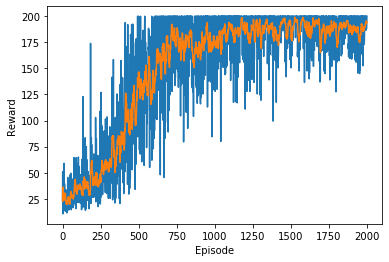

Varince of reward = 3636.7422424374995


In [22]:
plt.plot(np.mean(all_rewards, axis = 0))
plt.plot(np.mean(mean_rewards, axis = 0))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Varince of reward = {}'.format(np.var(np.mean(all_rewards, axis = 0))))

In [23]:
df = pd.DataFrame()
df['rewards'] = np.mean(all_rewards, axis = 0)
df['mean10_rewards'] = np.mean(mean_rewards, axis = 0)

In [24]:
df.to_csv('D:/Reinforcement_Learning/df_reinforce_2_trajectories_baseline_2000.csv', index=False)